<a href="https://colab.research.google.com/github/liangzhaobest/LZ_repository/blob/master/gan-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys
import os
import numpy as np

class GAN():
    def __init__(self):
        # --------------------------------- #
        #   行28，列28，也就是mnist的shape
        # --------------------------------- #
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        # 28,28,1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        # adam优化器
        optimizer = Adam(0.0002, 0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        self.generator = self.build_generator()
        
        gan_input = Input(shape=(self.latent_dim,))
        img = self.generator(gan_input)
        # 在训练generate的时候不训练discriminator
        self.discriminator.trainable = False
        # 对生成的假图片进行预测
        validity = self.discriminator(img)
        self.combined = Model(gan_input, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):
        # --------------------------------- #
        #   生成器，输入一串随机数字
        # --------------------------------- #
        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        # ----------------------------------- #
        #   评价器，对输入进来的图片进行评价
        # ----------------------------------- #
        model = Sequential()
        # 输入一张图片
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        # 判断真伪
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        # 获得数据
        (X_train, _), (_, _) = mnist.load_data()

        # 进行标准化
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # 创建标签
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # --------------------------- #
            #   随机选取batch_size个图片
            #   对discriminator进行训练
            # --------------------------- #
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            gen_imgs = self.generator.predict(noise)

            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # --------------------------- #
            #  训练generator
            # --------------------------- #
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):

        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    if not os.path.exists("./images"):
        os.makedirs("./images")
    gan = GAN()
    gan.train(epochs=30000, batch_size=256, sample_interval=200)

Streaming output truncated to the last 5000 lines.
25000 [D loss: 0.557871, acc.: 70.12%] [G loss: 1.260803]
25001 [D loss: 0.544306, acc.: 71.88%] [G loss: 1.221225]
25002 [D loss: 0.576510, acc.: 67.77%] [G loss: 1.229807]
25003 [D loss: 0.580114, acc.: 70.31%] [G loss: 1.212663]
25004 [D loss: 0.553252, acc.: 72.27%] [G loss: 1.163916]
25005 [D loss: 0.526896, acc.: 76.17%] [G loss: 1.181783]
25006 [D loss: 0.540824, acc.: 72.46%] [G loss: 1.232612]
25007 [D loss: 0.515511, acc.: 73.83%] [G loss: 1.341281]
25008 [D loss: 0.543839, acc.: 71.48%] [G loss: 1.294601]
25009 [D loss: 0.551123, acc.: 68.75%] [G loss: 1.284324]
25010 [D loss: 0.538913, acc.: 75.78%] [G loss: 1.229740]
25011 [D loss: 0.552762, acc.: 72.27%] [G loss: 1.237871]
25012 [D loss: 0.569938, acc.: 70.31%] [G loss: 1.229625]
25013 [D loss: 0.573448, acc.: 68.55%] [G loss: 1.169387]
25014 [D loss: 0.562461, acc.: 70.12%] [G loss: 1.210791]
25015 [D loss: 0.536381, acc.: 75.59%] [G loss: 1.239182]
25016 [D loss: 0.5680

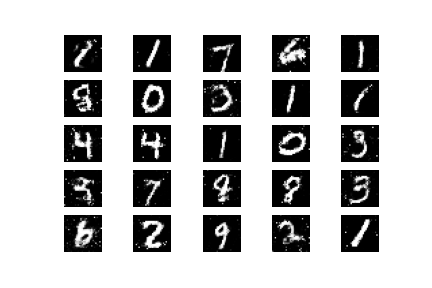

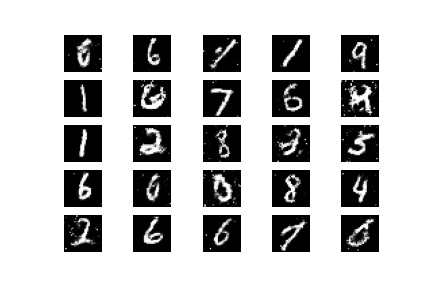